# Simulation

In [3]:
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import scipy
%matplotlib inline

In [4]:
import numpy as np
import scipy.stats
from scipy.linalg import svd, diagsvd, block_diag
from numpy.linalg import inv
import numpy.linalg as la
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import chi2, norm

In [23]:
def SNR_report(SNR):
    # Set seed for reproducibility
    np.random.seed(123)

    # Initial parameters
    TT = 200  # length of time-series data
    N = 300   # number of stocks
    theta = SNR  # SNR in L2 norm
    n_trial = 200  # number of simulations

    # Generate multivariate normal data
    mu_B = np.array([0, 0, 0])
    Sigma_B = np.diag([1, 1, 1])

    B_0 = np.random.multivariate_normal(mu_B, Sigma_B, N)

    # Adjustments for null hypothesis
    B_index_1 = 0
    B_index_2 = 1
    B_index_3 = 2
    B_0[B_index_2, :] = B_0[B_index_1, :]  # copy rows

    # Factor loadings under canonical condition
    mu_f = np.array([0, 0, 0])
    # Sigma_f = np.diag([1, 1, 1]) * (theta / (3.091527 / np.sqrt(0.1)))**2 # change the coefficient since R and python generate different Sigma_u
    Sigma_f = np.diag([1, 1, 1]) * (theta * 0.10496443374524415)**2
    res_BF_svd = svd(B_0 @ np.sqrt(Sigma_f), full_matrices=False)
    W = res_BF_svd[0]
    Sig = diagsvd(res_BF_svd[1], len(res_BF_svd[1]), len(res_BF_svd[1]))
    B = W @ Sig

    # Generate noise covariance matrix
    rho_max = 0.5
    num_block = 20
    n_sub = N // num_block
    Sigma_u = None

    for i in range(num_block):
        rho = np.random.uniform(0, rho_max)
        auto_corr_matrix = rho ** np.abs(np.arange(n_sub)[:, None] - np.arange(n_sub))
        if Sigma_u is None:
            Sigma_u = auto_corr_matrix
        else:
            Sigma_u = block_diag(Sigma_u, auto_corr_matrix)

    # Estimation and thresholding of noise covariance matrix
    C_thres = 1.0
    thres = C_thres * (1 / np.sqrt(N) + np.sqrt(np.log(N) / TT))

    # Placeholder for results arrays, similar to R's array initialization
    # Initialize results arrays
    B_CI_sum = np.zeros((N, n_trial))
    F_CI_sum = np.zeros((TT, n_trial))
    # F_test_N_sum = np.zeros((4, n_trial))# whole null, whole alter, sub null, sub alter
    # F_test_D_sum = np.zeros((4, n_trial))
    # F_test_AM_sum = np.zeros((4, n_trial))
    # F_test_Bai_sum = np.zeros((4, n_trial))
    F_test_sum = pd.DataFrame(index=np.linspace(0, 1, 5), columns=np.arange(n_trial))
    F_test_sum.index.name = 'delta' # different row corresponds to different alternative strength
    B_rownorm_CI_sum = np.zeros((N, n_trial))
    B_2row_CI_sum = np.zeros(n_trial)
    B_2row_alter_CI_sum = np.zeros(n_trial)

    # Simulations
    for k in tqdm(range(n_trial)):
        
        F_0 = np.random.multivariate_normal(mu_f, Sigma_f, TT)
        U_0 = np.random.multivariate_normal(np.zeros(N), Sigma_u, TT).T
        C_0 = B_0.dot(F_0.T)
        Y_0 = C_0 + U_0

        # Ground truth under canonical condition: factor realization
        F_1 = F_0 - np.ones(TT)[:, None] * F_0.mean(axis=0)
        FF = F_1.dot(inv(np.sqrt(Sigma_f))).dot(res_BF_svd[2].T) # Transpose to match R's output

        # De-mean the data Y
        Y = Y_0 - Y_0.mean(axis=1).reshape(-1, 1).dot(np.ones((1, TT))) 
        # wrong!!!!: Y_0.mean(axis=0) * np.ones(TT)[:, None].T
        # !!!!!!!!! demean has error !!!!!!

        res_svd = svd(Y, full_matrices=False)
        Sig_hat = np.diag(res_svd[1][:3]) / np.sqrt(TT)
        W_hat = res_svd[0][:, :3]
        V_hat = res_svd[2][:3, :].T # Transpose to match R's output

        B_hat = W_hat.dot(Sig_hat)
        F_hat = V_hat * np.sqrt(TT)

        # More computations needed for tests and estimations as per your R script
        # These would include PCA analysis, rotation matrix calculations, noise covariance estimations,
        # and other statistical measures you have outlined in the script.

        # Compute the SVD for groundtruth rotation matrix
        res_svd_ntl = svd(B.dot(FF.T), full_matrices=False)
        W_ntl = res_svd_ntl[0][:, :3]
        V_ntl = res_svd_ntl[2][:3, :].T # Transpose to match R's output
        Sig_ntl = diagsvd(res_svd_ntl[1][:3], 3, 3) / np.sqrt(TT)

        res_svd_W = svd(W_hat.T.dot(W_ntl), full_matrices=False)
        R_W = res_svd_W[0].dot(res_svd_W[2]) # Not Transpose to match R's output

        res_svd_V = svd(V_hat.T.dot(V_ntl), full_matrices=False)
        R_V = res_svd_V[0].dot(res_svd_V[2]) # Not Transpose to match R's output

        Q = W.T.dot(W_ntl)
        J = Sig.dot(Q).dot(inv(Sig_ntl))
        H = R_V.dot(J.T)

        # Estimate noise covariance matrix by hard-thresholding
        Sig_u_pivot = Y.dot(Y.T) / TT - B_hat.dot(B_hat.T)
        Corr_u_pivot = np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))).dot(Sig_u_pivot).dot(np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))))
        idx = np.abs(Corr_u_pivot) > thres
        tmp = np.diag(np.ones(N))
        tmp[idx] = Corr_u_pivot[idx]
        Sig_u_hat = np.diag(np.sqrt(np.diag(Sig_u_pivot))).dot(tmp).dot(np.diag(np.sqrt(np.diag(Sig_u_pivot))))

        # Groundtruth of factor loading after rotation
        B_gt = B.dot(inv(H))
        Chi_B = (1 / ((1 / TT) * np.diag(Sig_u_hat))) * np.diag((B_hat - B_gt).dot((B_hat - B_gt).T))

        # Groundtruth of factor realization after rotation
        F_gt = FF.dot(H.T)
        ######  np.diag(np.diag(Sig_u_hat))  is wrong
        Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
        Chi_F = np.diag((F_hat - F_gt).dot(inv(Q_V)).dot((F_hat - F_gt).T))

        B_CI_sum[:, k] = Chi_B
        F_CI_sum[:, k] = Chi_F

        # Row norm computations
        B_ntl = W_ntl.dot(Sig_ntl)
        B_ntl_row_norm_square = np.diag(B_ntl.dot(B_ntl.T))
        B_hat_row_norm_square = np.diag(B_hat.dot(B_hat.T))
        B_row_norm_square = np.diag(B.dot(B.T))
        B_rownorm_CI_sum[:, k] = (B_row_norm_square - B_hat_row_norm_square) / (2 / np.sqrt(TT) * np.sqrt(np.diag(Sig_u_hat)) * np.sqrt(B_hat_row_norm_square))

        # Test two rows of B -- under Null and Alternative
        B_2row_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_2, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_2, B_index_2] - 2 * Sig_u_hat[B_index_1, B_index_2])
        B_2row_alter_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_3, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_3, B_index_3] - 2 * Sig_u_hat[B_index_1, B_index_3])

        # Tests the factor -- code here will include the calculations for Test.N and Test.D, using the methodology outlined
        
        w = np.array([1, 1, 0.5])
        
        # Subset time period
        t_set = np.arange(100, 112)  # subset period
        V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
        Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
        cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
        g = 2 * cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
        # Null scenario
        for delta in F_test_sum.index:
            v_set = FF[t_set, :] @ w + delta * g
            Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
            Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
            F_test_sum.loc[delta, k] = Test_N / Test_D

    # Assuming F.CI.sum and B.CI.sum are defined as per the previous discussions and have the appropriate dimensions

    # Calculate the chi-square and normal quantile values
    chi_square_95_df3 = chi2.ppf(0.95, df=3)
    normal_975 = norm.ppf(0.975)

    # Calculate means and standard deviations of row means where conditions are met
    F_CI_mean = np.mean(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
    F_CI_sd = np.std(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
    B_CI_mean = np.mean(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))
    B_CI_sd = np.std(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))

    print(f"Mean and SD for F.CI.sum Factor:")
    print(f"({F_CI_mean}, {F_CI_sd})")
    print(f"Mean and SD for B.CI.sum Beta:")
    print(f"({B_CI_mean}, {B_CI_sd})")
    # Mean and SD for absolute values of B.rownorm.CI.sum under normal quantile
    B_rownorm_CI_mean = np.mean(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))
    B_rownorm_CI_sd = np.std(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))

    print(f"Mean and SD for abs(B.rownorm.CI.sum) Systematic risk:")
    print(f"({B_rownorm_CI_mean}, {B_rownorm_CI_sd})")

    print('test')

    # Empirical rejection probability
    B_2row_CI_rejection = np.mean(B_2row_CI_sum > chi_square_95_df3)
    B_2row_alter_CI_rejection = np.mean(B_2row_alter_CI_sum > chi_square_95_df3)

    print(f"Rejection probabilities two sample test of Beta:")
    print(f"Null: {B_2row_CI_rejection}, Alter: {B_2row_alter_CI_rejection}")

    sub_null_alter_rejection = np.mean(F_test_sum > chi2.ppf(0.95, df=12-3), axis=1)
    print(f"Sub null/.../alter rejection rate: {sub_null_alter_rejection}")

    tmp = Sig[2,2]/np.sqrt(la.norm(Sigma_u, ord=2))
    print('SNR:')
    print(f'{tmp}')

In [24]:
SNR_report(5.0)

100%|██████████| 200/200 [01:35<00:00,  2.10it/s]

Mean and SD for F.CI.sum Factor:
(0.9316499999999999, 0.017910262421304692)
Mean and SD for B.CI.sum Beta:
(0.9343833333333333, 0.014953919961743214)
Mean and SD for abs(B.rownorm.CI.sum) Systematic risk:
(0.8921833333333333, 0.03453757615506141)
test
Rejection probabilities two sample test of Beta:
Null: 0.02, Alter: 1.0
Sub null/.../alter rejection rate: delta
0.00    0.000
0.25    0.000
0.50    0.505
0.75    0.945
1.00    0.995
dtype: float64
SNR:
5.0


In [25]:
SNR_report(4.5)

100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Mean and SD for F.CI.sum Factor:
(0.929675, 0.018262512833671033)
Mean and SD for B.CI.sum Beta:
(0.9328666666666666, 0.015387729599334078)
Mean and SD for abs(B.rownorm.CI.sum) Systematic risk:
(0.9014333333333333, 0.02971813886800076)
test
Rejection probabilities two sample test of Beta:
Null: 0.02, Alter: 1.0
Sub null/.../alter rejection rate: delta
0.00    0.000
0.25    0.000
0.50    0.250
0.75    0.895
1.00    0.980
dtype: float64
SNR:
4.500000000000001


# previous codes for all results

In [28]:
# Set seed for reproducibility
np.random.seed(123)

# Initial parameters
TT = 200  # length of time-series data
N = 300   # number of stocks
theta = 5.5  # SNR in L2 norm
n_trial = 200  # number of simulations

# Generate multivariate normal data
mu_B = np.array([0, 0, 0])
Sigma_B = np.diag([1, 1, 1])

B_0 = np.random.multivariate_normal(mu_B, Sigma_B, N)

# Adjustments for null hypothesis
B_index_1 = 0
B_index_2 = 1
B_index_3 = 2
B_0[B_index_2, :] = B_0[B_index_1, :]  # copy rows

# Factor loadings under canonical condition
mu_f = np.array([0, 0, 0])
# Sigma_f = np.diag([1, 1, 1]) * (theta / (3.091527 / np.sqrt(0.1)))**2 # change the coefficient since R and python generate different Sigma_u
Sigma_f = np.diag([1, 1, 1]) * (theta * 0.10496443374524415)**2
res_BF_svd = svd(B_0 @ np.sqrt(Sigma_f), full_matrices=False)
W = res_BF_svd[0]
Sig = diagsvd(res_BF_svd[1], len(res_BF_svd[1]), len(res_BF_svd[1]))
B = W @ Sig

# Generate noise covariance matrix
rho_max = 0.5
num_block = 20
n_sub = N // num_block
Sigma_u = None

for i in range(num_block):
    rho = np.random.uniform(0, rho_max)
    auto_corr_matrix = rho ** np.abs(np.arange(n_sub)[:, None] - np.arange(n_sub))
    if Sigma_u is None:
        Sigma_u = auto_corr_matrix
    else:
        Sigma_u = block_diag(Sigma_u, auto_corr_matrix)

# Estimation and thresholding of noise covariance matrix
C_thres = 1.0
thres = C_thres * (1 / np.sqrt(N) + np.sqrt(np.log(N) / TT))

# Placeholder for results arrays, similar to R's array initialization
# Initialize results arrays
B_CI_sum = np.zeros((N, n_trial))
F_CI_sum = np.zeros((TT, n_trial))
# F_test_N_sum = np.zeros((4, n_trial))# whole null, whole alter, sub null, sub alter
# F_test_D_sum = np.zeros((4, n_trial))
# F_test_AM_sum = np.zeros((4, n_trial))
# F_test_Bai_sum = np.zeros((4, n_trial))
F_test_sum = pd.DataFrame(index=np.linspace(0, 1, 5), columns=np.arange(n_trial))
F_test_sum.index.name = 'delta' # different row corresponds to different alternative strength
B_rownorm_CI_sum = np.zeros((N, n_trial))
B_2row_CI_sum = np.zeros(n_trial)
B_2row_alter_CI_sum = np.zeros(n_trial)

B_structural_null_sum = np.zeros(n_trial)

# Simulations
for k in tqdm(range(n_trial)):
    
    F_0 = np.random.multivariate_normal(mu_f, Sigma_f, TT)
    U_0 = np.random.multivariate_normal(np.zeros(N), Sigma_u, TT).T
    C_0 = B_0.dot(F_0.T)
    Y_0 = C_0 + U_0

    # Ground truth under canonical condition: factor realization
    F_1 = F_0 - np.ones(TT)[:, None] * F_0.mean(axis=0)
    FF = F_1.dot(inv(np.sqrt(Sigma_f))).dot(res_BF_svd[2].T) # Transpose to match R's output

    # De-mean the data Y
    Y = Y_0 - Y_0.mean(axis=1).reshape(-1, 1).dot(np.ones((1, TT))) 
    # wrong!!!!: Y_0.mean(axis=0) * np.ones(TT)[:, None].T
    # !!!!!!!!! demean has error !!!!!!

    res_svd = svd(Y, full_matrices=False)
    Sig_hat = np.diag(res_svd[1][:3]) / np.sqrt(TT)
    W_hat = res_svd[0][:, :3]
    V_hat = res_svd[2][:3, :].T # Transpose to match R's output

    B_hat = W_hat.dot(Sig_hat)
    F_hat = V_hat * np.sqrt(TT)

    # More computations needed for tests and estimations as per your R script
    # These would include PCA analysis, rotation matrix calculations, noise covariance estimations,
    # and other statistical measures you have outlined in the script.

    # Estimate noise covariance matrix by hard-thresholding
    Sig_u_pivot = Y.dot(Y.T) / TT - B_hat.dot(B_hat.T)
    Corr_u_pivot = np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))).dot(Sig_u_pivot).dot(np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))))
    idx = np.abs(Corr_u_pivot) > thres
    tmp = np.diag(np.ones(N))
    tmp[idx] = Corr_u_pivot[idx]
    Sig_u_hat = np.diag(np.sqrt(np.diag(Sig_u_pivot))).dot(tmp).dot(np.diag(np.sqrt(np.diag(Sig_u_pivot))))

    # # Compute the SVD for groundtruth rotation matrix
    # res_svd_ntl = svd(B.dot(FF.T), full_matrices=False)
    # W_ntl = res_svd_ntl[0][:, :3]
    # V_ntl = res_svd_ntl[2][:3, :].T # Transpose to match R's output
    # Sig_ntl = diagsvd(res_svd_ntl[1][:3], 3, 3) / np.sqrt(TT)

    # res_svd_W = svd(W_hat.T.dot(W_ntl), full_matrices=False)
    # R_W = res_svd_W[0].dot(res_svd_W[2]) # Not Transpose to match R's output

    # res_svd_V = svd(V_hat.T.dot(V_ntl), full_matrices=False)
    # R_V = res_svd_V[0].dot(res_svd_V[2]) # Not Transpose to match R's output

    # Q = W.T.dot(W_ntl)
    # J = Sig.dot(Q).dot(inv(Sig_ntl))
    # H = R_V.dot(J.T)

    # # Groundtruth of factor loading after rotation
    # B_gt = B.dot(inv(H))
    # Chi_B = (1 / ((1 / TT) * np.diag(Sig_u_hat))) * np.diag((B_hat - B_gt).dot((B_hat - B_gt).T))

    # # Groundtruth of factor realization after rotation
    # F_gt = FF.dot(H.T)
    # ######  np.diag(np.diag(Sig_u_hat))  is wrong
    # Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    # Chi_F = np.diag((F_hat - F_gt).dot(inv(Q_V)).dot((F_hat - F_gt).T))

    # B_CI_sum[:, k] = Chi_B
    # F_CI_sum[:, k] = Chi_F

    # # Row norm computations
    # B_ntl = W_ntl.dot(Sig_ntl)
    # B_ntl_row_norm_square = np.diag(B_ntl.dot(B_ntl.T))
    # B_hat_row_norm_square = np.diag(B_hat.dot(B_hat.T))
    # B_row_norm_square = np.diag(B.dot(B.T))
    # B_rownorm_CI_sum[:, k] = (B_row_norm_square - B_hat_row_norm_square) / (2 / np.sqrt(TT) * np.sqrt(np.diag(Sig_u_hat)) * np.sqrt(B_hat_row_norm_square))

    # # Test two rows of B -- under Null and Alternative
    # B_2row_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_2, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_2, B_index_2] - 2 * Sig_u_hat[B_index_1, B_index_2])
    # B_2row_alter_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_3, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_3, B_index_3] - 2 * Sig_u_hat[B_index_1, B_index_3])

    # # Tests the factor -- code here will include the calculations for Test.N and Test.D, using the methodology outlined
    
    # w = np.array([1, 1, 0.5])
    
    # # Subset time period
    # t_set = np.arange(100, 112)  # subset period
    # V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
    # Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    # cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
    # g = 2 * cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
    # # Null scenario
    # for delta in F_test_sum.index:
    #     v_set = FF[t_set, :] @ w + delta * g
    #     Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    #     Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    #     F_test_sum.loc[delta, k] = Test_N / Test_D

    ###### structural break test
    index_beta = 0
    t_set_1 = np.arange(0, TT//2)  # subset period
    t_set_2 = np.arange(0, TT//2) + TT//2
    # regression 1 and 2
    beta_1 = np.linalg.inv(F_hat[t_set_1, :].T @ F_hat[t_set_1, :]) @ F_hat[t_set_1, :].T @ Y[index_beta, t_set_1].T
    beta_2 = np.linalg.inv(F_hat[t_set_2, :].T @ F_hat[t_set_2, :]) @ F_hat[t_set_2, :].T @ Y[index_beta, t_set_2].T
    # covariance inverse
    cov_inv_beta = 1/( (Sig_u_hat + W_hat@W_hat.T@Sig_u_hat + Sig_u_hat@W_hat@W_hat.T + W_hat@W_hat.T@Sig_u_hat@W_hat@W_hat.T )[index_beta, index_beta] ) \
    * np.linalg.inv( np.linalg.inv(F_hat[t_set_1, :].T @ F_hat[t_set_1, :]) + np.linalg.inv(F_hat[t_set_2, :].T @ F_hat[t_set_2, :]) )
    # test statistics
    B_structural_null_sum[k] = (beta_1 - beta_2).T @ cov_inv_beta @ (beta_1 - beta_2)



    # #################### Whole period
    # t_set = np.arange(TT)  # full time period
    # V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
    # # Null scenario
    # v_set = FF[t_set, :] @ w
    # Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    # Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_N_sum[0, k] = Test_N
    # F_test_D_sum[0, k] = Test_D
    
    # G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_D_Bai = v_set.T @ V_pinv.T @ Q_V_CSHAC @ V_pinv @ v_set
    # tao_set = G_set / np.sqrt(F_test_D_Bai)
    # F_test_Bai_sum[0, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    # F_test_Bai_sum[1, k] = np.max(np.abs(tao_set))
    
    # # Alternative scenario
    # cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
    # v_set = FF[t_set, :] @ w + cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
    # Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    # Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_N_sum[1, k] = Test_N
    # F_test_D_sum[1, k] = Test_D
    
    # G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_D_Bai = v_set.T @ V_pinv.T @ Q_V_CSHAC @ V_pinv @ v_set
    # tao_set = G_set / np.sqrt(F_test_D_Bai)
    # F_test_Bai_sum[2, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    # F_test_Bai_sum[3, k] = np.max(np.abs(tao_set))
    
    ################## Subset time period
    # NT_sub = int(np.floor(np.sqrt(min(N, TT))))
    # Q_V_CSHAC = (N / NT_sub) * inv(Sig_hat) @ W_hat[:NT_sub, :].T @ Sig_u_pivot[:NT_sub, :NT_sub] @ W_hat[:NT_sub, :] @ inv(Sig_hat)
    # t_set = np.arange(100, 112)  # subset period
    # V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
    # Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    # Null scenario
    # v_set = FF[t_set, :] @ w
    # Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    # Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_N_sum[2, k] = Test_N
    # F_test_D_sum[2, k] = Test_D
    
    # G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    # tao_set = G_set / np.sqrt(Test_D)
    # F_test_AM_sum[0, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    # F_test_AM_sum[1, k] = np.max(np.abs(tao_set))
    
    # # Alternative scenario for the subset period
    # cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
    # v_set = FF[t_set, :] @ w + 2 * cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
    # Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    # Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    # F_test_N_sum[3, k] = Test_N
    # F_test_D_sum[3, k] = Test_D
    
    # G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    # tao_set = G_set / np.sqrt(Test_D)
    # F_test_AM_sum[2, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    # F_test_AM_sum[3, k] = np.max(np.abs(tao_set))

100%|██████████| 200/200 [01:08<00:00,  2.92it/s]


# structural break test for beta

In [51]:
def SNR_report_structural_beta(SNR):
    # Set seed for reproducibility
    np.random.seed(123)

    # Initial parameters
    TT = 200  # length of time-series data
    N = 300   # number of stocks
    theta = SNR  # SNR in L2 norm
    n_trial = 200  # number of simulations

    # Generate multivariate normal data
    mu_B = np.array([0, 0, 0])
    Sigma_B = np.diag([1, 1, 1])

    B_0 = np.random.multivariate_normal(mu_B, Sigma_B, N)

    # Adjustments for null hypothesis
    B_index_1 = 0
    B_index_2 = 1
    B_index_3 = 2
    B_0[B_index_2, :] = B_0[B_index_1, :]  # copy rows

    # Factor loadings under canonical condition
    mu_f = np.array([0, 0, 0])
    # Sigma_f = np.diag([1, 1, 1]) * (theta / (3.091527 / np.sqrt(0.1)))**2 # change the coefficient since R and python generate different Sigma_u
    Sigma_f = np.diag([1, 1, 1]) * (theta * 0.10496443374524415)**2
    res_BF_svd = svd(B_0 @ np.sqrt(Sigma_f), full_matrices=False)
    W = res_BF_svd[0]
    Sig = diagsvd(res_BF_svd[1], len(res_BF_svd[1]), len(res_BF_svd[1]))
    B = W @ Sig

    # Generate noise covariance matrix
    rho_max = 0.5
    num_block = 20
    n_sub = N // num_block
    Sigma_u = None

    for i in range(num_block):
        rho = np.random.uniform(0, rho_max)
        auto_corr_matrix = rho ** np.abs(np.arange(n_sub)[:, None] - np.arange(n_sub))
        if Sigma_u is None:
            Sigma_u = auto_corr_matrix
        else:
            Sigma_u = block_diag(Sigma_u, auto_corr_matrix)

    # Estimation and thresholding of noise covariance matrix
    C_thres = 1.0
    thres = C_thres * (1 / np.sqrt(N) + np.sqrt(np.log(N) / TT))

    B_structural_test_sum = pd.DataFrame(index=np.linspace(0, 1, 5), columns=np.arange(n_trial))
    B_structural_test_sum.index.name = 'delta' # different row corresponds to different alternative strength

    ###### structural break test setup
    index_beta = 0
    t_set_1 = np.arange(0, TT//2)  # subset period
    t_set_2 = np.arange(0, TT//2) + TT//2
    

    SNR_sum = pd.DataFrame(index=np.linspace(0, 1, 5), columns=['SNR_1', 'SNR_2'])
    SNR_sum.index.name = 'delta'
    for delta in SNR_sum.index:
        SNR_sum.loc[delta, 'SNR_1'] = Sig[2,2]/np.sqrt(la.norm(Sigma_u, ord=2))
        
        # set the structural break
        B_0_change = B_0.copy()
        B_0_change[index_beta, :] = B_0[index_beta, :] + delta*np.linalg.norm(B_0[index_beta, :], 2)
        res_BF_svd_2 = svd(B_0_change @ np.sqrt(Sigma_f), full_matrices=False)
        Sig_2 = diagsvd(res_BF_svd_2[1], len(res_BF_svd_2[1]), len(res_BF_svd_2[1]))
        SNR_sum.loc[delta, 'SNR_2'] = Sig_2[2,2]/np.sqrt(la.norm(Sigma_u, ord=2))

    # Simulations
    for k in tqdm(range(n_trial)):

        F_0 = np.random.multivariate_normal(mu_f, Sigma_f, TT)
        U_0 = np.random.multivariate_normal(np.zeros(N), Sigma_u, TT).T
        C_0 = B_0.dot(F_0.T)

        # Y_0 = C_0 + U_0
        for delta in B_structural_test_sum.index:

            # set the structural break
            B_0_change = B_0.copy()
            B_0_change[index_beta, :] = B_0[index_beta, :] + delta*np.linalg.norm(B_0[index_beta, :], 2)
            C_0[:,t_set_2] = B_0_change.dot(F_0[t_set_2,:].T)

            Y_0 = C_0 + U_0

            # De-mean the data Y
            Y = Y_0 - Y_0.mean(axis=1).reshape(-1, 1).dot(np.ones((1, TT))) 
            # wrong!!!!: Y_0.mean(axis=0) * np.ones(TT)[:, None].T
            # !!!!!!!!! demean has error !!!!!!

            res_svd = svd(Y, full_matrices=False)
            Sig_hat = np.diag(res_svd[1][:3]) / np.sqrt(TT)
            W_hat = res_svd[0][:, :3]
            V_hat = res_svd[2][:3, :].T # Transpose to match R's output

            B_hat = W_hat.dot(Sig_hat)
            F_hat = V_hat * np.sqrt(TT)

            # More computations needed for tests and estimations as per your R script
            # These would include PCA analysis, rotation matrix calculations, noise covariance estimations,
            # and other statistical measures you have outlined in the script.

            # Estimate noise covariance matrix by hard-thresholding
            Sig_u_pivot = Y.dot(Y.T) / TT - B_hat.dot(B_hat.T)
            Corr_u_pivot = np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))).dot(Sig_u_pivot).dot(np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))))
            idx = np.abs(Corr_u_pivot) > thres
            tmp = np.diag(np.ones(N))
            tmp[idx] = Corr_u_pivot[idx]
            Sig_u_hat = np.diag(np.sqrt(np.diag(Sig_u_pivot))).dot(tmp).dot(np.diag(np.sqrt(np.diag(Sig_u_pivot))))

            ###### structural break test
            # regression 1 and 2
            beta_1 = np.linalg.inv(F_hat[t_set_1, :].T @ F_hat[t_set_1, :]) @ F_hat[t_set_1, :].T @ Y[index_beta, t_set_1].T
            beta_2 = np.linalg.inv(F_hat[t_set_2, :].T @ F_hat[t_set_2, :]) @ F_hat[t_set_2, :].T @ Y[index_beta, t_set_2].T
            # covariance inverse
            cov_inv_beta = 1/( (Sig_u_hat + W_hat@W_hat.T@Sig_u_hat + Sig_u_hat@W_hat@W_hat.T + W_hat@W_hat.T@Sig_u_hat@W_hat@W_hat.T )[index_beta, index_beta] ) \
            * np.linalg.inv( np.linalg.inv(F_hat[t_set_1, :].T @ F_hat[t_set_1, :]) + np.linalg.inv(F_hat[t_set_2, :].T @ F_hat[t_set_2, :]) )
            # test statistics
            B_structural_test_sum.loc[delta,k] = (beta_1 - beta_2).T @ cov_inv_beta @ (beta_1 - beta_2)

    # Empirical rejection probability
    chi_square_95_df3 = chi2.ppf(0.95, df=3)
    # B_structural_null_rejection = np.mean(B_structural_null_sum > chi_square_95_df3)
    # B_structural_alter_rejection = np.mean(B_structural_alter_sum > chi_square_95_df3)

    print(f"Rejection probabilities structural break test of Beta:")
    # print(f"Null: {B_structural_null_rejection}, Alter: {B_structural_alter_rejection}")
    sub_null_alter_rejection = np.mean(B_structural_test_sum > chi_square_95_df3, axis=1)
    print(f"Sub null/.../alter rejection rate: {sub_null_alter_rejection}")
    print(SNR_sum)


In [53]:
SNR_report_structural_beta(5.0)

100%|██████████| 200/200 [03:21<00:00,  1.01s/it]

Rejection probabilities structural break test of Beta:
Sub null/.../alter rejection rate: delta
0.00    0.030
0.25    0.445
0.50    0.970
0.75    1.000
1.00    1.000
dtype: float64
      SNR_1     SNR_2
delta                
0.00    5.0       5.0
0.25    5.0  4.993274
0.50    5.0  4.988698
0.75    5.0  4.986247
1.00    5.0  4.985827


In [52]:
SNR_report_structural_beta(4.5)

100%|██████████| 200/200 [03:18<00:00,  1.01it/s]

Rejection probabilities structural break test of Beta:
Sub null/.../alter rejection rate: delta
0.00    0.035
0.25    0.355
0.50    0.945
0.75    1.000
1.00    1.000
dtype: float64
      SNR_1     SNR_2
delta                
0.00    4.5       4.5
0.25    4.5  4.493947
0.50    4.5  4.489828
0.75    4.5  4.487623
1.00    4.5  4.487244


## report results SNR=5.5 (structural break only)

In [44]:
# Empirical rejection probability
chi_square_95_df3 = chi2.ppf(0.95, df=3)
# B_structural_null_rejection = np.mean(B_structural_null_sum > chi_square_95_df3)
# B_structural_alter_rejection = np.mean(B_structural_alter_sum > chi_square_95_df3)

print(f"Rejection probabilities structural break test of Beta:")
# print(f"Null: {B_structural_null_rejection}, Alter: {B_structural_alter_rejection}")
sub_null_alter_rejection = np.mean(B_structural_test_sum > chi_square_95_df3, axis=1)
print(f"Sub null/.../alter rejection rate: {sub_null_alter_rejection}")

Rejection probabilities structural break test of Beta:
Sub null/.../alter rejection rate: delta
0.00    0.03
0.25    0.51
0.50    0.99
0.75    1.00
1.00    1.00
dtype: float64


## report results SNR=5.5 (no structural break test)

In [22]:


# Assuming F.CI.sum and B.CI.sum are defined as per the previous discussions and have the appropriate dimensions

# Calculate the chi-square and normal quantile values
chi_square_95_df3 = chi2.ppf(0.95, df=3)
normal_975 = norm.ppf(0.975)

# Calculate means and standard deviations of row means where conditions are met
F_CI_mean = np.mean(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
F_CI_sd = np.std(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
B_CI_mean = np.mean(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))
B_CI_sd = np.std(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))

print(f"Mean and SD for F.CI.sum Factor:")
print(f"({F_CI_mean}, {F_CI_sd})")
print(f"Mean and SD for B.CI.sum Beta:")
print(f"({B_CI_mean}, {B_CI_sd})")
# Mean and SD for absolute values of B.rownorm.CI.sum under normal quantile
B_rownorm_CI_mean = np.mean(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))
B_rownorm_CI_sd = np.std(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))

print(f"Mean and SD for abs(B.rownorm.CI.sum) Systematic risk:")
print(f"({B_rownorm_CI_mean}, {B_rownorm_CI_sd})")

print('test')

# Empirical rejection probability
B_2row_CI_rejection = np.mean(B_2row_CI_sum > chi_square_95_df3)
B_2row_alter_CI_rejection = np.mean(B_2row_alter_CI_sum > chi_square_95_df3)

print(f"Rejection probabilities two sample test of Beta:")
print(f"Null: {B_2row_CI_rejection}, Alter: {B_2row_alter_CI_rejection}")

sub_null_alter_rejection = np.mean(F_test_sum > chi2.ppf(0.95, df=12-3), axis=1)
print(f"Sub null/.../alter rejection rate: {sub_null_alter_rejection}")

# # F.test.sum calculations
# F_test_sum = F_test_N_sum / F_test_D_sum
# whole_null_alter_rejection = np.mean(F_test_sum[:2, :] > chi2.ppf(0.95, df=TT-3), axis=1)
# sub_null_alter_rejection = np.mean(F_test_sum[2:4, :] > chi2.ppf(0.95, df=9), axis=1)

# print(f"Whole null/alter rejection rate: {whole_null_alter_rejection}")
# print(f"Sub null/alter rejection rate: {sub_null_alter_rejection}")

# # Empirical rejections for Bai sums and AM sums
# F_test_Bai_rejection = np.mean(F_test_Bai_sum[[1, 3], :] > norm.ppf(0.5 * (1 + 0.95**(1/TT))), axis=1)
# F_test_AM_rejection = np.mean(F_test_AM_sum[[1, 3], :] > 0.05, axis=1)

# print(f"F.test.Bai empirical rejection: {F_test_Bai_rejection}")
# print(f"F.test.AM empirical rejection: {F_test_AM_rejection}")


Mean and SD for F.CI.sum Factor:
(0.933275, 0.017878740867298206)
Mean and SD for B.CI.sum Beta:
(0.9357666666666666, 0.01474490495805999)
Mean and SD for abs(B.rownorm.CI.sum) Systematic risk:
(0.8825166666666668, 0.039088926394398024)
test
Rejection probabilities two sample test of Beta:
Null: 0.02, Alter: 1.0
Sub null/.../alter rejection rate: delta
0.00    0.000
0.25    0.000
0.50    0.745
0.75    0.990
1.00    1.000
dtype: float64


## sanity check and SNR

In [4]:

# Assuming that B, FF, B_0, F_1, R_W, R_V, and Q have been defined previously in the translation

# Sum of absolute differences between two matrix products
difference_sum = np.sum(np.abs(B @ FF.T - B_0 @ F_1.T))
print("Sum of absolute differences:", difference_sum)

# Sum of the smaller singular values from the previously computed SVD 'res_svd_ntl'
# Note: Ensure 'res_svd_ntl' has been calculated and includes singular values.
min_dimension = min(N, TT)
if len(res_svd_ntl[1]) > 3:  # Assuming index starts from 0 in Python
    small_singular_values_sum = np.sum(np.abs(res_svd_ntl[1][3:min_dimension]))
    print("Sum of smaller singular values:", small_singular_values_sum)
else:
    print("No smaller singular values to sum.")

# Matrix multiplications to check orthogonality of rotation matrices
R_W_orthogonality = R_W @ R_W.T
R_V_orthogonality = R_V @ R_V.T
Q_orthogonality = Q @ Q.T

print("R.W * R.W.T:", R_W_orthogonality)
print("R.V * R.V.T:", R_V_orthogonality)
print("Q * Q.T:", Q_orthogonality)


Sum of absolute differences: 2.7232052638120045e-11
Sum of smaller singular values: 6.29268214347239e-12
R.W * R.W.T: [[1.00000000e+00 2.14878281e-16 1.18660259e-16]
 [2.14878281e-16 1.00000000e+00 1.39520832e-16]
 [1.18660259e-16 1.39520832e-16 1.00000000e+00]]
R.V * R.V.T: [[ 1.00000000e+00 -2.55446066e-16  1.70781572e-16]
 [-2.55446066e-16  1.00000000e+00  1.91654625e-16]
 [ 1.70781572e-16  1.91654625e-16  1.00000000e+00]]
Q * Q.T: [[ 1.00000000e+00  6.58944208e-17 -1.05562419e-16]
 [ 6.58944208e-17  1.00000000e+00 -1.78838770e-16]
 [-1.05562419e-16 -1.78838770e-16  1.00000000e+00]]


In [4]:
# print SNR
Sig[2,2]/np.sqrt(la.norm(Sigma_u, ord=2))

10.0

# plot the statistics

In [ ]:
df_raw = pd.read_csv('/Chi3.csv', index_col='time', parse_dates=['time'])
df = df_raw.drop(df_raw.columns[0], axis=1)
df['Critical value']=scipy.stats.chi2.ppf(0.95, 12-3)
df

,Mkt-RF,SMB,HML,Critical value
time,,,,
2003-01-01,0.346330,4.056721,12.819896,16.918978
2003-02-01,0.508150,3.421403,17.716503,16.918978
2003-03-01,0.351061,2.935742,20.058382,16.918978
2003-04-01,0.402918,2.759007,7.436294,16.918978
2003-05-01,0.326499,3.287302,8.398986,16.918978
...,...,...,...,...
2021-09-01,4.630631,32.418750,13.050594,16.918978
2021-10-01,4.789563,14.666590,9.981305,16.918978
2021-11-01,4.110816,16.340782,9.011673,16.918978


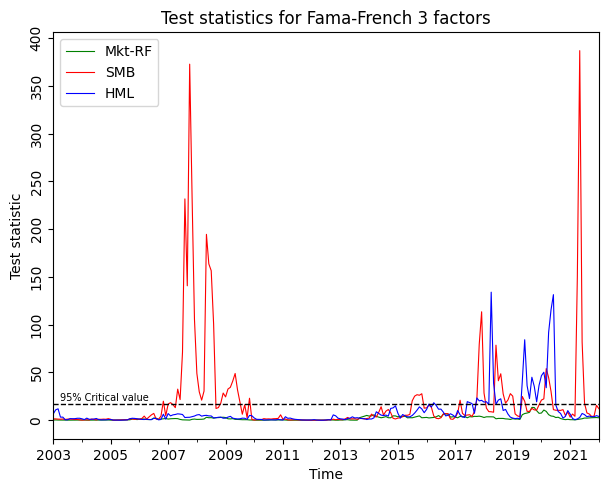

In [ ]:
# Chi1
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()


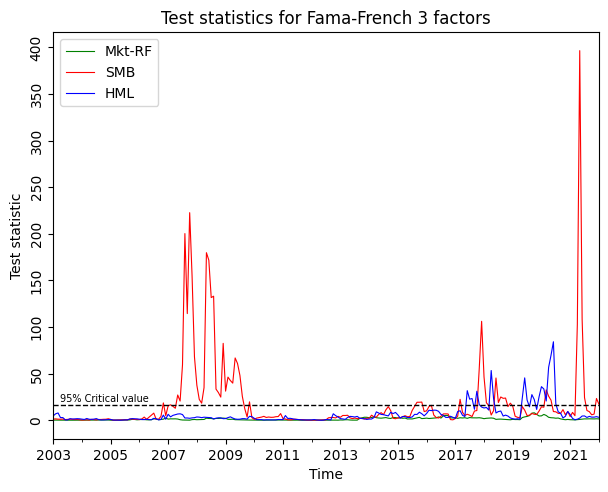

In [ ]:
# Chi2
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()

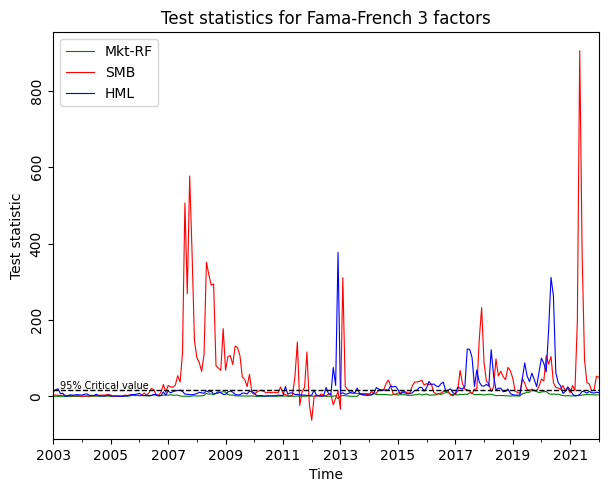

In [ ]:
# Chi3
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()